# transversity-combined

In [1]:
import sys,os
os.chdir('../../')
import itertools as it
import numpy as np
import pandas as pd
from scipy.special import beta
from scipy.integrate import quad
import pylab as py
from  matplotlib import rc
from matplotlib.colors import LogNorm
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import matplotlib
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from tools.tools import save,load,lprint,load_config
from tools.bar import BAR
from resman import RESMAN
import nest
import obslib.moments.moments
from matplotlib.mlab import griddata

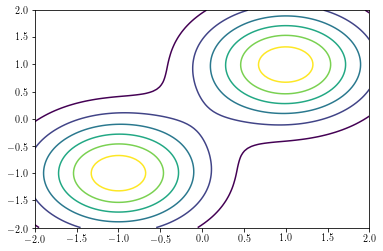

In [2]:
x=np.linspace(-2,2,100)
y=np.linspace(-2,2,100)
x, y = np.meshgrid(x, y)
z=np.exp(-(x-1)**2-(y-1)**2)+np.exp(-(x+1)**2-(y+1)**2)
py.contour(x,y, z)

In [3]:
x=np.linspace(-2,2,100)
y=np.linspace(-2,2,100)
x, y = np.meshgrid(x, y)
z=np.exp(-(x-1)**2-(y-1)**2)+np.exp(-(x+1)**2-(y+1)**2)

x = x.flatten()
y = y.flatten()
z = z.flatten()
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
zgrid = griddata(x,y,z, xgrid, ygrid)#,interp='linear')
py.contour(xgrid, ygrid, zgrid)


RuntimeError: To use interp='nn' (Natural Neighbor interpolation) in griddata, natgrid must be installed. Either install it from http://github.com/matplotlib/natgrid or use interp='linear' instead.

In [4]:
best1=4 # from only sidis run
best2=4 # from sidis+lattice run

## setup

In [5]:
class RUN:
    
    def __init__(self,path,nestfile,inputfile):
        self.conf=conf=load_config('%s/%s'%(path,inputfile))
        self.resman=RESMAN(self.conf);
        self.parman=self.resman.conf['parman']
        nest=load('%s/%s'%(path,nestfile))
        wmax=np.amax(nest['weights'])
        wmin_cut=wmax*1e-7
        self.weights=[nest['weights'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
        self.samples=[nest['samples'][j] for j in range(len(nest['weights'])) if nest['weights'][j]>wmin_cut]
        self.weights/=np.sum(self.weights)
        self.moments=obslib.moments.moments.MOMENTS(self.conf)
        self.nest=nest

In [6]:
path='outputs/transversity/mc-transversity/transversity-0-v0/'
nestfile='nest%d'%best1
inputfile='transversity-0.py'
run1=RUN(path,nestfile,inputfile)

loading sidis data sets 3013

In [7]:
path='outputs/transversity/mc-transversity/transversity-lattice-0-v0/'
nestfile='nest%d'%best2
inputfile='transversity-lattice-0.py'
run2=RUN(path,nestfile,inputfile)

loading moments data sets 1000

In [8]:
print 'run1 LogZ =',run1.nest['logz'][-1]
print 'run2 LogZ =',run2.nest['logz'][-1]

run1 LogZ = 43.8248465253
run2 LogZ = 41.7693338308


In [9]:
def get_kinematics():
    tabs=run1.resman.sidisres.tabs
    X,Z,Q2,pT=[],[],[],[]
    for k in tabs:X=np.append(tabs[k]['x'],X)
    for k in tabs:Z=np.append(tabs[k]['z'],Z)
    for k in tabs:Q2=np.append(tabs[k]['Q2'],Q2)
    for k in tabs:pT=np.append(tabs[k]['pT'],pT)
    return {'X':X,'Z':Z,'Q2':Q2,'pT':pT}
kin=get_kinematics()

## parameters

In [10]:
def plot_params(k,kk):
    order=run1.parman.order
    get_idx=lambda _kk: [i for i in range(len(order)) if order[i][1]==k if order[i][2]==_kk][0]
    nrows,ncols=1,5
    py.figure(figsize=(ncols*3,nrows*2))
    for i in range(len(kk)):
        ax=py.subplot(nrows,ncols,i+1)
        par1=np.transpose(run1.samples)[get_idx(kk[i])]
        par2=np.transpose(run2.samples)[get_idx(kk[i])]
        pmin=run1.conf['params'][k][kk[i]]['min']
        pmax=run1.conf['params'][k][kk[i]]['max']
        R=(pmin,pmax)
        ax.hist(par1,histtype='stepfilled',range=R,weights=run1.weights,bins=10,facecolor='Yellow',edgecolor='k')
        ax.hist(par2,histtype='stepfilled',range=R,weights=run2.weights,bins=10,facecolor='none',edgecolor='r',hatch='...')
        ax.set_xlim(pmin,pmax)
        ax.set_title('%s-%s'%(k,kk[i]))
    py.tight_layout()


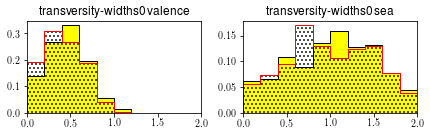

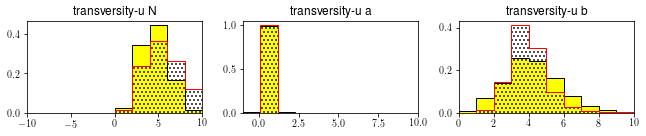

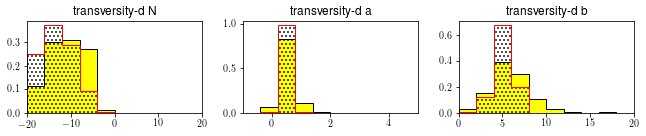

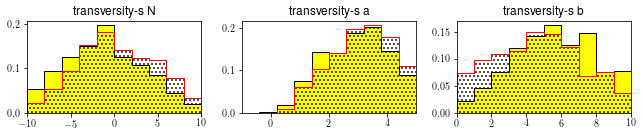

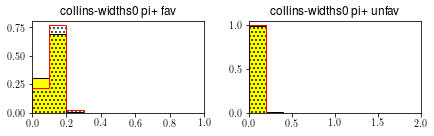

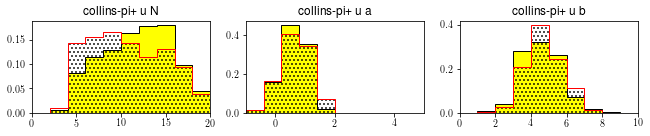

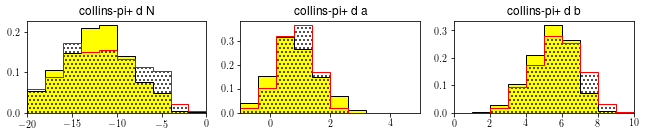

In [11]:
plot_params('transversity',['widths0 valence','widths0 sea'])
plot_params('transversity',['u N','u a','u b'])
plot_params('transversity',['d N','d a','d b'])
plot_params('transversity',['s N','s a','s b'])
plot_params('collins',['widths0 pi+ fav','widths0 pi+ unfav'])
plot_params('collins',['pi+ u N','pi+ u a','pi+ u b'])
plot_params('collins',['pi+ d N','pi+ d a','pi+ d b'])
# plot_params('collins',['widths0 k+ fav','widths0 k+ unfav'])
# plot_params('collins',['k+ u N','k+ u a','k+ u b'])
# plot_params('collins',['k+ d N','k+ d a','k+ d b'])

## Data vs Theory

In [12]:
RAW1=load('outputs/transversity/transversity-0-v0/raw%d'%best1)
RAW2=load('outputs/transversity/transversity-lattice-0-v0/raw%d'%best2)

In [13]:
def process_raw(run,RAW):
    RES=RAW['RES']
    THY=RAW['THY']
    for k in RES:
        if k=='sidis': 
            for kk in RES[k]: 
                thy =np.einsum('k,ki',run.weights,np.array(THY[k][kk]))
                dthy=np.einsum('k,ki',run.weights,(np.array(THY[k][kk])-thy)**2)**0.5
                residuals=np.einsum('k,ki',run.weights,RES[k][kk])
                run.resman.sidisres.tabs[kk]['thy']=thy
                run.resman.sidisres.tabs[kk]['dthy']=dthy
                run.resman.sidisres.tabs[kk]['residuals']=residuals
                run.resman.sidisres.tabs[kk]['chi2']=residuals**2
                run.resman.sidisres.tabs[kk]=pd.DataFrame(run.resman.sidisres.tabs[kk])
        if k=='moments':
            for kk in RES[k]: 
                thy =np.einsum('k,ki',run.weights,np.array(THY[k][kk]))
                dthy=np.einsum('k,ki',run.weights,(np.array(THY[k][kk])-thy)**2)**0.5
                residuals=np.einsum('k,ki',run.weights,RES[k][kk])
                run.resman.momres.tabs[kk]['thy']=thy
                run.resman.momres.tabs[kk]['dthy']=dthy
                run.resman.momres.tabs[kk]['residuals']=residuals
                run.resman.momres.tabs[kk]['chi2']=residuals**2
                run.resman.momres.tabs[kk]=pd.DataFrame(run.resman.momres.tabs[kk])

In [14]:
process_raw(run1,RAW1)
process_raw(run2,RAW2)

In [15]:
pd.options.display.float_format = '{:,.1f}'.format

In [16]:
RES1=RAW1['RES']
RES2=RAW2['RES']
NPTS=0
CHI21=0
CHI22=0
D={}
for k in ['had','tar','dep','col','chi2','npts','chi2(+lattice)']: D[k]=[]
for k in RES1:
    for kk in RES1[k]:
        if k=='sidis':
            D['tar'].append(run1.resman.sidisres.tabs[kk]['target'].values[0])
            D['dep'].append(run1.resman.sidisres.tabs[kk]['dependence'].values[0])
            D['col'].append(run1.resman.sidisres.tabs[kk]['col'].values[0].upper().strip())
            D['had'].append(run1.resman.sidisres.tabs[kk]['hadron'].values[0])
            D['chi2'].append(np.sum(run1.resman.sidisres.tabs[kk]['chi2']))
            D['chi2(+lattice)'].append(np.sum(run2.resman.sidisres.tabs[kk]['chi2']))
            D['npts'].append(run1.resman.sidisres.tabs[kk]['value'].size)
D=pd.DataFrame(D)
D = D[['col', 'tar', 'had', 'dep', 'npts','chi2','chi2(+lattice)']]
D=D.sort_values(by=['col','tar'])
print D.to_string(index=False)
print '\nNtot =',np.sum(D.npts)
print 'Chi2tot =',np.sum(D.chi2)
print 'Chi2tot(+lattice) =',np.sum(D['chi2(+lattice)'])

col       tar  had dep  npts  chi2  chi2(+lattice)
COMPASS  deuteron  pi+   x     6   1.9             2.0
COMPASS  deuteron  pi+  pT     6   3.9             3.9
COMPASS  deuteron  pi+   z     6   1.8             1.8
COMPASS  deuteron  pi-   x     6   3.2             3.2
COMPASS  deuteron  pi-  pT     6   5.7             5.6
COMPASS  deuteron  pi-   z     6   6.3             6.4
COMPASS    proton  pi+   z     6   1.5             1.6
COMPASS    proton  pi+   x     7   5.7             5.6
COMPASS    proton  pi+  pt     6   2.6             2.5
COMPASS    proton  pi-  pt     6   1.0             1.0
COMPASS    proton  pi-   x     7   3.1             3.2
COMPASS    proton  pi-   z     6   7.5             7.7
 HERMES    proton  pi-  pt     5   2.8             2.8
 HERMES    proton  pi-   z     6   2.6             2.5
 HERMES    proton  pi+  pt     5   2.2             2.1
 HERMES    proton  pi+   x     5   5.2             5.3
 HERMES    proton  pi+   z     6   3.8             3.8
 HERMES    pro

## x dependence

In [17]:
def get_key(K,tar,had,col,tabs,dep):
    kk=None
    for k in K:
        d=tabs[k]
        if tar==d['target'].values[0] \
            and had==d['hadron'].values[0] \
            and dep==d['dependence'].values[0] \
            and col==d['col'].values[0].upper().strip(): kk=k
    return kk

In [18]:
tabs=run1.resman.sidisres.tabs
def plot(idx,dep,tar,had,col=None,msg=None,legend=False,text=False,offset=False,offset2=False):
    k=get_key(tabs.keys(),tar,had,col,tabs,dep)
    d1=run1.resman.sidisres.tabs[k]
    d2=run2.resman.sidisres.tabs[k]
    ax=py.subplot(nrows,ncols,idx)
    dep=d1['dependence'].values[0]
    #obs=d['obs'].values[0]
    tar=d1['target'].values[0]
    had=d1['hadron'].values[0]
    if dep=='pt': dep='pT'
    sign=1
    if col=='COMPASS': sign=-1
    f=100
    shift=0
    if '-' in had:
        vmin=np.amin(d1[dep])
        vmax=np.amax(d1[dep])
        dv=vmax-vmin
        shift=0.03*dv
    if offset==False: shift=0
    shift2=np.zeros(d1[dep].size)
    if offset2==True: 
        vmin=np.amin(d1[dep])
        vmax=np.amax(d1[dep])
        dv=vmax-vmin
        shift2[-1]=-dv*0.03
    if '-' in had: 
        e=ax.errorbar(d1[dep]+shift+shift2,f*sign*d1['value'],f*d1['alpha'], fmt='ko', mfc='white',markersize=4)
        b2=ax.fill_between(d2[dep],f*sign*(d2['thy']-d2['dthy']),f*sign*(d2['thy']+d2['dthy']),color='b',alpha=0.3)
        l2,=ax.plot(d2[dep],f*sign*d2['thy'],'b-')
    if '+' in had: 
        e=ax.errorbar(d1[dep]+shift+shift2,f*sign*d1['value'],f*d1['alpha'],fmt='ko',markersize=4)
        b2=ax.fill_between(d2[dep],f*sign*(d2['thy']-d2['dthy']),f*sign*(d2['thy']+d2['dthy']),color='r',alpha=0.3)  
        l2,=ax.plot(d2[dep],f*sign*d2['thy'],'r-')
        
    if dep=='x':
        ax.set_xlabel(r'$\boldsymbol{x}$',size=23)
        ax.xaxis.set_label_coords(0.95, -0.04)
        ax.set_xlim(-0.01,0.3)
        ax.set_xticks([0,0.1,0.2,0.3])
        ax.set_xticklabels([r'$\boldsymbol{0}$',r'$\boldsymbol{0.1}$',r'$\boldsymbol{0.2}$',''])
        
    if dep=='z':
        ax.set_xlabel(r'$\boldsymbol{z}$',size=23)
        ax.xaxis.set_label_coords(0.75, -0.04)
        ax.set_xlim(0.19,0.62)
        ax.set_xticks([0.2,0.3,0.4,0.5,0.6])
        ax.set_xticklabels([r'$\boldsymbol{0.2}$','',r'$\boldsymbol{0.4}$','',r'$\boldsymbol{0.6}$',''])
        
    if dep=='pT':
        ax.set_xlabel(r'$\boldsymbol{P_{h\perp}}$',size=21)
        ax.xaxis.set_label_coords(0.9, -0.06)
        ax.set_xlim(0.15,0.86)
        ax.set_xticks([0.2,0.4,0.6,0.8])
        ax.set_xticklabels([r'$\boldsymbol{0.2}$',r'$\boldsymbol{0.4}$',r'$\boldsymbol{0.6}$',''])
        

    #if dep=='pT':ax.set_xlim(0.2,0.65)
    #ax.tick_params(axis='both', which='major', labelsize=16)
    #ax.tick_params(axis='both', which='major', labelsize=20)
    #ax.set_ylabel(obs)
    #ax.set_title('%s %s %s'%(tar,had.replace('+','').replace('-',''),col))
    #ax.set_xlim(0,0.3)
    #ax.set_ylim(-.1,.1)
    #ax.set_xticklabels([])
    ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
    if text: ax.text(0.1,0.1,msg,transform=ax.transAxes,size=15)
    if legend: return ax,(b2,l2),e
    else: return ax
    

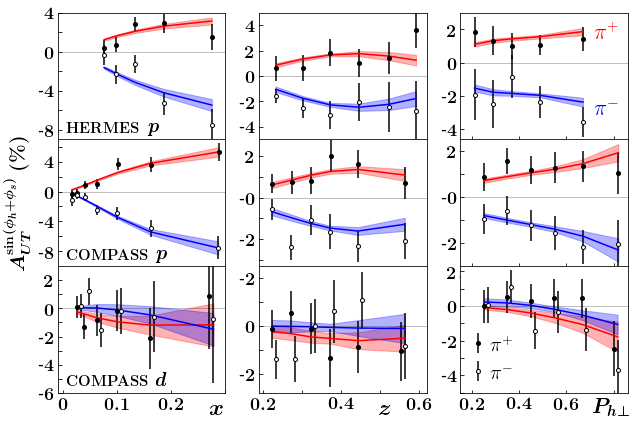

In [19]:
nrows,ncols=3,3
py.figure(figsize=(ncols*3,nrows*2))

ax=plot(1,'x','proton','pi+','HERMES')
ax=plot(1,'x','proton','pi-','HERMES')
ax.text(0.05,0.05,r'$\boldsymbol{\rm HERMES}$',transform=ax.transAxes,size=15)
ax.text(0.535,0.06,r'$\boldsymbol{p}$',transform=ax.transAxes,size=19)
ax.set_xticks([''])
ax.set_ylim(-9,4)
ax.set_yticks([-8,-6,-4,-2,0,2,4])
ax.set_yticklabels([r'-$\boldsymbol{8}$','',r'-$\boldsymbol{4}$','',r'$\boldsymbol{0}$','',r'$\boldsymbol{4}$'])
ax.axhline(0,c='k',ls='-',lw=0.5,alpha=0.5)

ax=plot(2,'z','proton','pi+','HERMES')
ax=plot(2,'z','proton','pi-','HERMES')
ax.set_xticks([''])
ax.set_ylim(-5,5)
ax.set_yticks([-4,-2,0,2,4])
ax.set_yticklabels([r'-$\boldsymbol{4}$',r'-$\boldsymbol{2}$',r'$\boldsymbol{0}$',r'$\boldsymbol{2}$',r'$\boldsymbol{4}$'])
ax.axhline(0,c='k',ls='-',lw=0.5,alpha=0.5)

ax=plot(3,'pt','proton','pi+','HERMES')
ax=plot(3,'pt','proton','pi-','HERMES')
ax.text(0.8,0.8,r'$\pi^+$',color='r',alpha=1,size=22,transform=ax.transAxes)
ax.text(0.8,0.2,r'$\pi^-$',color='b',alpha=1,size=22,transform=ax.transAxes)
ax.set_xlabel('')
ax.set_ylim(-4.6,3)
ax.set_yticks([-4,-2,0,2])
ax.set_yticklabels([r'-$\boldsymbol{4}$',r'-$\boldsymbol{2}$',r'$\boldsymbol{0}$',r'$\boldsymbol{2}$'])
ax.axhline(0,c='k',ls='-',lw=0.5,alpha=0.5)

ax=plot(4,'x','proton','pi+','COMPASS')
ax=plot(4,'x','proton','pi-','COMPASS')
ax.text(0.05,0.05,r'$\boldsymbol{\rm COMPASS}$',transform=ax.transAxes,size=15)
ax.text(0.58,0.06,r'$\boldsymbol{p}$',transform=ax.transAxes,size=19)
ax.set_xticks([''])
ax.set_ylim(-10,7)
ax.set_yticks([-8,-6,-4,-2,0,2,4,6])
ax.set_yticklabels([r'-$\boldsymbol{8}$','',r'-$\boldsymbol{4}$','',r'$\boldsymbol{0}$','',r'$\boldsymbol{4}$'])
ax.set_ylabel(r'$\boldsymbol{A_{UT}^{\sin(\phi_h+\phi_s)}~(\%)}$',size=20)
ax.axhline(0,c='k',ls='-',lw=0.5,alpha=0.5)

ax=plot(5,'z','proton','pi+','COMPASS')
ax=plot(5,'z','proton','pi-','COMPASS')
ax.set_xticks([''])
ax.set_ylim(-3.3,2.8)
ax.set_yticks([-3,-2,-1,0,1,2])
ax.set_yticklabels(['',r'-$\boldsymbol{2}$','',r'-$\boldsymbol{0}$','',r'$\boldsymbol{2}$'])
ax.axhline(0,c='k',ls='-',lw=0.5,alpha=0.5)

ax=plot(6,'pt','proton','pi+','COMPASS')
ax=plot(6,'pt','proton','pi-','COMPASS')
ax.set_xlabel('')
ax.set_ylim(-3,2.5)
ax.set_yticks([-3,-2,-1,0,1,2])
ax.set_yticklabels(['',r'-$\boldsymbol{2}$','',r'-$\boldsymbol{0}$','',r'$\boldsymbol{2}$'])
ax.axhline(0,c='k',ls='-',lw=0.5,alpha=0.5)

ax=plot(7,'x','deuteron','pi+','COMPASS',offset2=True)
ax=plot(7,'x','deuteron','pi-','COMPASS',offset=True,offset2=True)
ax.text(0.05,0.05,r'$\boldsymbol{\rm COMPASS}$',transform=ax.transAxes,size=15)
ax.text(0.58,0.06,r'$\boldsymbol{d}$',transform=ax.transAxes,size=19)
ax.set_ylim(-6,3)
ax.set_yticks([-6,-5,-4,-3,-2,-1,0,1,2])
ax.set_yticklabels([r'-$\boldsymbol{6}$','',r'-$\boldsymbol{4}$','',r'-$\boldsymbol{2}$','',r'$\boldsymbol{0}$','',r'$\boldsymbol{2}$'])
ax.axhline(0,c='k',ls='-',lw=0.5,alpha=0.5)

ax=plot(8,'z','deuteron','pi+','COMPASS',offset2=True)
ax=plot(8,'z','deuteron','pi-','COMPASS',offset=True,offset2=True)
ax.set_ylim(-2.8,2.5)
ax.set_yticks([-2,-1,0,1,2])
ax.set_yticklabels([r'-$\boldsymbol{2}$','',r'$\boldsymbol{0}$','',r'-$\boldsymbol{2}$'])
ax.axhline(0,c='k',ls='-',lw=0.5,alpha=0.5)

ax,b,ep=plot(9,'pT','deuteron','pi+','COMPASS',legend=True,offset2=True)
ax,b,em=plot(9,'pT','deuteron','pi-','COMPASS',legend=True,offset=True,offset2=True)
ax.set_ylim(-5,2.3)
ax.set_yticks([-5,-4,-3,-2,-1,0,1,2])
ax.set_yticklabels(['',r'-$\boldsymbol{4}$','',r'-$\boldsymbol{2}$','',r'$\boldsymbol{0}$','',r'$\boldsymbol{2}$'])
ax.axhline(0,c='k',ls='-',lw=0.5,alpha=0.5)

ax.legend([ep,em],[r'$\pi^+$',r'$\pi^-$'],loc=3,frameon=0,fontsize=20,bbox_to_anchor=(-0.12,-0.06), handletextpad=-0.4)

py.subplots_adjust(wspace=0.2, hspace=0,left=0.1, bottom=0.07, right=0.98, top=0.95)
#py.savefig('/Users/wmelnitc/Physics/Papers/TMD/gT17/paper/prl_final/dvt.pdf')

## PDFs and FFs

In [20]:
def calc(run,func,msg):
    RAW=[]
    bar=BAR(msg,len(run.samples))
    for i in range(len(run.samples)):
        par=run.samples[i]
        run.parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    f =np.einsum('k,kif->if',run.weights,RAW)
    df=np.einsum('k,kif->if',run.weights,(RAW-f)**2)**0.5
    f=np.einsum('if->fi',f)
    df=np.einsum('if->fi',df)
    return {'f':f,'df':df}

## Transversity

In [21]:
X1=10**np.linspace(-3,-1)
X2=np.linspace(0.101,0.999)
X=np.append(X1,X2)
h1=calc(run1,lambda : [run1.resman.conf['transversity'].get_C(x,1) for x in X],'calc h1')
h2=calc(run2,lambda : [run2.resman.conf['transversity'].get_C(x,1) for x in X],'calc h2')

calc h1 [100%]
calc h2 [100%]


In [22]:
Z1=10**np.linspace(-3,-1)
Z2=np.linspace(0.101,0.999)
Z=np.append(Z1,Z2)
Hpi1=calc(run1,lambda : [run1.resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')
Hpi2=calc(run2,lambda : [run2.resman.conf['collins'].get_C(z,1,'pi+') for z in Z],'calc H(pi+)')

calc H(pi+) [100%]
calc H(pi+) [100%]


In [34]:
data={}
data['X']=X
data['u']=h1['f'][1]
data['du']=h1['df'][1]
data['d']=h1['f'][3]
data['dd']=h1['df'][3]
pd.options.display.float_format = '{:,.4f}'.format
data=pd.DataFrame(data)
data.to_excel('sidis.xlsx')

In [35]:
data={}
data['X']=X
data['u']=h2['f'][1]
data['du']=h2['df'][1]
data['d']=h2['f'][3]
data['dd']=h2['df'][3]
pd.options.display.float_format = '{:,.4f}'.format
data=pd.DataFrame(data)
data.to_excel('sidis+lattice.xlsx')
data

,X,d,dd,du,u
0,0.0010,-0.4632,0.2804,0.0507,0.0616
1,0.0011,-0.4825,0.2861,0.0521,0.0650
2,0.0012,-0.5026,0.2918,0.0536,0.0686
3,0.0013,-0.5235,0.2976,0.0550,0.0724
4,0.0015,-0.5453,0.3035,0.0566,0.0764
5,0.0016,-0.5681,0.3095,0.0581,0.0806
6,0.0018,-0.5919,0.3155,0.0597,0.0852
7,0.0019,-0.6167,0.3216,0.0614,0.0899
8,0.0021,-0.6425,0.3278,0.0631,0.0950
9,0.0023,-0.6694,0.3340,0.0648,0.1003


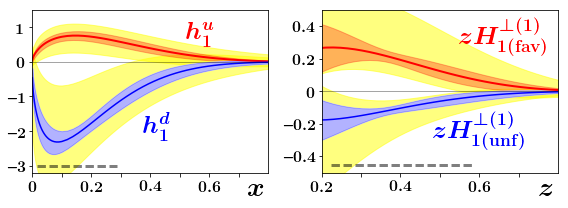

In [23]:
nrows,ncols=1,2
py.figure(figsize=(ncols*4,nrows*3))

def plot(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)

    band1=ax.fill_between(X,(h1['f'][1]-h1['df'][1]),(h1['f'][1]+h1['df'][1]),color='Yellow',alpha=0.5)
    band1=ax.fill_between(X,(h1['f'][3]-h1['df'][3]),(h1['f'][3]+h1['df'][3]),color='Yellow',alpha=0.5)

    #band2=ax.fill_between(X,(h2['f'][1]-h2['df'][1]),(h2['f'][1]+h2['df'][1]),color='w',alpha=1)
    band2=ax.fill_between(X,(h2['f'][1]-h2['df'][1]),(h2['f'][1]+h2['df'][1]),color='r',alpha=0.3)
    line2,=ax.plot(X,h2['f'][1],'r-',lw=2)

    band2=ax.fill_between(X,(h2['f'][3]-h2['df'][3]),(h2['f'][3]+h2['df'][3]),color='w',alpha=1)
    band2=ax.fill_between(X,(h2['f'][3]-h2['df'][3]),(h2['f'][3]+h2['df'][3]),color='b',alpha=0.3)
    line2,=ax.plot(X,h2['f'][3],'b-')

    ax.set_yticks([-3,-2,-1,0,1])


    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{x}$',size=27)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,.2,.4,.6])
    xmin=np.amin(kin['X'])
    xmax=np.amax(kin['X'])
    ymin, ymax = ax.get_ylim()

    dy=0.1*(ymax-ymin)
    line,=ax.plot([xmin,xmax],[ymin+dy,ymin+dy],'k-',lw=3,alpha=0.5,ls='--')
    return ax,(band1),(band2,line2),line
 
def plotpi(idx,flav,ylims=None):
    ax=py.subplot(nrows,ncols,idx)
    
    band1=ax.fill_between(Z,Z*(Hpi1['f'][1]-Hpi1['df'][1]),Z*(Hpi1['f'][1]+Hpi1['df'][1]),color='Yellow',alpha=0.5)
    band1=ax.fill_between(Z,Z*(Hpi1['f'][3]-Hpi1['df'][3]),Z*(Hpi1['f'][3]+Hpi1['df'][3]),color='Yellow',alpha=0.5)
 
    #band2=ax.fill_between(Z,(Hpi2['f'][1]-Hpi2['df'][1]),(Hpi2['f'][1]+Hpi2['df'][1]),color='w')
    band2=ax.fill_between(Z,Z*(Hpi2['f'][1]-Hpi2['df'][1]),Z*(Hpi2['f'][1]+Hpi2['df'][1]),color='r',alpha=0.3)
    line2,=ax.plot(Z,Z*Hpi2['f'][1],'r-',lw=2)

    band2=ax.fill_between(Z,Z*(Hpi2['f'][3]-Hpi2['df'][3]),Z*(Hpi2['f'][3]+Hpi2['df'][3]),color='w')
    band2=ax.fill_between(Z,Z*(Hpi2['f'][3]-Hpi2['df'][flav]),Z*(Hpi2['f'][3]+Hpi2['df'][3]),color='b',alpha=0.3)
    line2,=ax.plot(Z,Z*Hpi2['f'][3],'b-')


    if ylims!=None: ax.set_ylim(ylims[0],ylims[1])
    ax.set_xlabel(r'$\boldsymbol{z}$',size=27)
    ax.xaxis.set_label_coords(0.95, -0.02)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,0.2,0.4,0.6])
    zmin=np.amin(kin['Z'])
    zmax=np.amax(kin['Z'])
    ymin, ymax = ax.get_ylim()
    dy=0.05*(ymax-ymin)
    line,=ax.plot([zmin,zmax*0.99],[ymin+dy,ymin+dy],'k-',ls='--',lw=3,alpha=0.5)
    return ax,(band1),(band2,line2),line


ax,b1,b2,l=plot(1,1,[-3.5,1.5])
ax.text(0.65,0.78,r'$\boldsymbol{h_1^u}$',size=25,transform=ax.transAxes,color='r')
ax.text(0.47,0.2,r'$\boldsymbol{h_1^d}$',size=25,transform=ax.transAxes,color='b')
ax.set_xlim(0,0.8)
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.2}$','',r'$\boldsymbol{0.4}$','',r'$\boldsymbol{0.6}$',''])
ax.axhline(0,ls='-',lw=0.5,color='k',alpha=0.7)
ax.set_ylim(-3.2,1.5)
ax.set_yticks([-3,-2,-1,0,1])
ax.set_yticklabels([r'--$\boldsymbol{3}$',r'--$\boldsymbol{2}$',r'--$\boldsymbol{1}$',r'$\boldsymbol{0}$',r'$\boldsymbol{1}$'])
#ax.set_yticklabels([r'$-3$',r'$-2$',r'$-1$',r'$0$',r'$1$'])


ax,b1,b2,l=plotpi(2,2,[-0.5,0.5])
ax.text(0.58,0.75,r'$\boldsymbol{zH_{1 {\rm (fav)}}^{\perp (1)}}$',size=25,transform=ax.transAxes,color='r')
ax.text(0.47,0.17,r'$\boldsymbol{zH_{1 {\rm (unf)}}^{\perp (1)}}$',size=25,transform=ax.transAxes,color='b')
ax.set_xlim(0.2,0.8)
ax.set_xticks([0.2,0.3,0.4,0.5,0.6,0.7])
ax.set_xticklabels([r'$\boldsymbol{0.2}$','',r'$\boldsymbol{0.4}$','',r'$\boldsymbol{0.6}$',''])
ax.axhline(0,ls='-',lw=0.5,color='k',alpha=0.7)
ax.set_ylim(-0.5,0.5)
ax.set_yticks([-0.4,-0.2,0,0.2,0.4])
ax.set_yticklabels([r'--$\boldsymbol{0.4}$',r'--$\boldsymbol{0.2}$',r'$\boldsymbol{0}$',r'$\boldsymbol{0.2}$',r'$\boldsymbol{0.4}$'])

py.tight_layout()
#py.savefig('/Users/wmelnitc/Physics/Papers/TMD/gT17/paper/prl_final/transversity-collins.pdf')

## gT

In [35]:
def calc2(run,func,msg):
    RAW=[]
    bar=BAR(msg,len(run.samples))
    for i in range(len(run.samples)):
        par=run.samples[i]
        run.parman.set_new_params(par)
        RAW.append(func())
        bar.next()
    bar.finish()
    RAW=np.array(RAW)
    return RAW

gT1=calc2(run1,lambda : run1.moments.get_gT(),'calc gT1')
gT2=calc2(run2,lambda : run2.moments.get_gT(),'calc gT2')

uv1=calc2(run1,lambda : run1.moments.get_flav('uv'),'calc uv1')
dv1=calc2(run1,lambda : run1.moments.get_flav('dv'),'calc dv1')
uv2=calc2(run2,lambda : run2.moments.get_flav('uv'),'calc uv2')
dv2=calc2(run2,lambda : run2.moments.get_flav('dv'),'calc dv2')


calc gT1 [100%]
calc gT2 [100%]
calc uv1 [100%]
calc dv1 [100%]
calc uv2 [100%]
calc dv2 [100%]


In [36]:
Euv1 = np.einsum('k,k',uv1,run1.weights)
Suv1 = np.einsum('k,k',(uv1-Euv1)**2,run1.weights)**0.5
Euv2 = np.einsum('k,k',uv2,run2.weights)
Suv2 = np.einsum('k,k',(uv2-Euv2)**2,run2.weights)**0.5

Edv1 = np.einsum('k,k',dv1,run1.weights)
Sdv1 = np.einsum('k,k',(dv1-Edv1)**2,run1.weights)**0.5
Edv2 = np.einsum('k,k',dv2,run2.weights)
Sdv2 = np.einsum('k,k',(dv2-Edv2)**2,run2.weights)**0.5

print 'uv1=%10.1f +/- %10.1f'%(Euv1,Suv1)
print 'uv2=%10.2f +/- %10.2f'%(Euv2,Suv2)
print 'dv1=%10.1f +/- %10.1f'%(Edv1,Sdv1)
print 'dv2=%10.2f +/- %10.2f'%(Edv2,Sdv2)

uv1=       0.3 +/-        0.3
uv2=      0.29 +/-       0.15
dv1=      -0.6 +/-        0.5
dv2=     -0.72 +/-       0.16


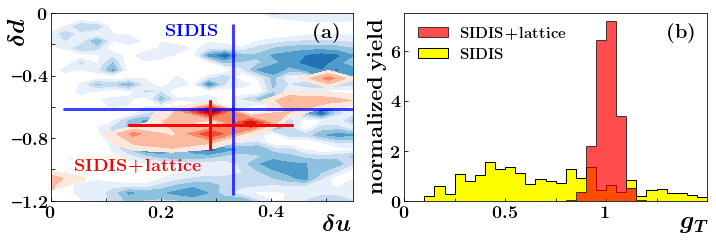

In [229]:
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
nrows,ncols=1,2
py.figure(figsize=(ncols*5,nrows*3.5))

##############################################
ax=py.subplot(121)

xgrid = np.linspace(uv1.min(), uv1.max(), 100)
ygrid = np.linspace(dv1.min(), dv1.max(), 100)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
zgrid = griddata(uv1,dv1,run1.weights, xgrid, ygrid)#,interp='linear')
zgrid/=np.amax(zgrid)
ax.contourf(xgrid, ygrid, zgrid,cmap=cm.Blues,levels=[0.15,0.3,0.45,0.6,0.75,0.9,1.05])

xgrid = np.linspace(uv2.min(), uv2.max(), 50)
ygrid = np.linspace(dv2.min(), dv2.max(), 50)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
zgrid = griddata(uv2,dv2,run2.weights, xgrid, ygrid)#,interp='linear')
zgrid/=np.amax(zgrid)
ct=ax.contourf(xgrid, ygrid, zgrid,cmap=cm.Reds,levels=[0.15,0.3,0.45,0.6,0.75,0.9,1.05])

ax.set_xlim(-.3,1.)
ax.set_ylim(-1.2,0)
ax.errorbar([Euv1],[Edv1],xerr=Suv1,yerr=Sdv1,fmt='b.',elinewidth=3,alpha=0.5)
ax.errorbar([Euv2],[Edv2],xerr=Suv2,yerr=Sdv2,fmt='r.',elinewidth=3,alpha=1)


ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
ax.set_xlabel(r'$\boldsymbol{\delta u}$',size=24)
ax.xaxis.set_label_coords(0.95, -0.07)
ax.set_xlim(0.0,0.55)
ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.2}$','',r'$\boldsymbol{0.4}$',''])
ax.set_ylabel(r'$\boldsymbol{\delta d}$',size=24)
ax.yaxis.set_label_coords(-0.07, 0.9)
ax.set_ylim(-1.2,0.0)
ax.set_yticks([-1.2,-1.0,-0.8,-0.6,-0.4,-0.2,0])
ax.set_yticklabels([r'--$\boldsymbol{1.2}$','',r'--$\boldsymbol{0.8}$','',r'--$\boldsymbol{0.4}$','',r'$\boldsymbol{0}$'])
ax.text(0.38,0.88,r'$\boldsymbol{\rm SIDIS}$',size=18,transform=ax.transAxes,color='b',alpha=1)
ax.text(0.08,0.16,r'$\boldsymbol{\rm SIDIS\!+\!lattice}$',size=18,transform=ax.transAxes,color='r',alpha=1)
ax.errorbar([Euv1],[Edv1],xerr=Suv1,yerr=Sdv1,fmt='b.',elinewidth=3,alpha=0.5)
ax.errorbar([Euv2],[Edv2],xerr=Suv2,yerr=Sdv2,fmt='r.',elinewidth=3,alpha=1)
ax.text(0.87,0.87,r'$\boldsymbol{\rm (a)}$',size=20,transform=ax.transAxes,color='k',alpha=1)

##############################################
ax=py.subplot(122)
toRGB=lambda p: (float(p[0])/255,float(p[1])/255,float(p[2])/255)
R=(0,1.5)
bins=30

ax.hist(gT2,histtype='stepfilled',range=R,weights=run2.weights,bins=bins,facecolor='r'\
   ,edgecolor='k'\
   ,label=r'$\boldsymbol{\rm SIDIS\!+\!lattice}$',normed=True,alpha=0.7,zorder=10);

ax.hist(gT1,histtype='stepfilled',range=R\
    ,weights=run1.weights,bins=bins\
    ,facecolor="Yellow",edgecolor='k',alpha=1\
    ,label=r'$\boldsymbol{\rm SIDIS}$',normed=True,zorder=0);

ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
ax.set_xlabel(r'$\boldsymbol{g_T}$',size=25)
ax.set_xlim([0,1.5])
ax.set_xticks([0,0.25,0.5,0.75,1,1.25])
ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.5}$','',r'$\boldsymbol{1}$',''])
ax.xaxis.set_label_coords(0.95, -0.07)
ax.set_ylabel(r'$\boldsymbol{\rm normalized~yield}$',size=22)
ax.set_ylim([0,7.5])
ax.set_yticks([0,2,4,6])
ax.set_yticklabels([r'$\boldsymbol{0}$',r'$\boldsymbol{2}$',r'$\boldsymbol{4}$',r'$\boldsymbol{6}$'])
ax.legend(frameon=False,fontsize=15,loc=2)
ax.text(0.87,0.87,r'$\boldsymbol{\rm (b)}$',size=20,transform=ax.transAxes,color='k',alpha=1)

py.tight_layout()
py.savefig('gT.pdf')

In [ ]:
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
nrows,ncols=1,2
py.figure(figsize=(ncols*5,nrows*5))

#x = x.flatten()
#y = y.flatten()
#z = z.flatten()
ax=py.subplot(121)
xgrid = np.linspace(uv1.min(), uv1.max(), 100)
ygrid = np.linspace(dv1.min(), dv1.max(), 100)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
zgrid = griddata(uv1,dv1,run1.weights, xgrid, ygrid)#,interp='linear')
#print np.amin(zgrid),np.amax(zgrid)
#zgrid[zgrid < 1e-3] = 0
#print np.amin(zgrid),np.amax(zgrid)
zgrid/=np.amax(zgrid)
#zgrid = np.ma.masked_where(zgrid < 5e-2, zgrid)
#ax.contour(xgrid, ygrid, zgrid,cmap=cm.Blues)
ax.contourf(xgrid, ygrid, zgrid,cmap=cm.Blues,levels=[0.15,0.3,0.45,0.6,0.75,0.9,1.05])
print ct.levels
#im = ax.imshow(zgrid, interpolation='quadric', origin='lower', cmap=cm.Blues, 
#             extent=(uv1.min(), uv1.max(),dv1.min(), dv1.max()),aspect=0.5)

ax.set_xlim(-.5,1.)
ax.set_ylim(-1.2,0)
ax.errorbar([Euv1],[Edv1],xerr=Suv1,yerr=Sdv1,fmt='b.',elinewidth=3,alpha=0.5)

#ax=py.subplot(122)

xgrid = np.linspace(uv2.min(), uv2.max(), 50)
ygrid = np.linspace(dv2.min(), dv2.max(), 50)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
zgrid = griddata(uv2,dv2,run2.weights, xgrid, ygrid)#,interp='linear')
zgrid/=np.amax(zgrid)
#zgrid = np.ma.masked_where(zgrid < 1e-2, zgrid)
#ct=ax.contour(xgrid, ygrid, zgrid,cmap=cm.Reds)
ct=ax.contourf(xgrid, ygrid, zgrid,cmap=cm.Reds,levels=[0.15,0.3,0.45,0.6,0.75,0.9,1.05])
print ct.levels
#im = ax.imshow(zgrid, interpolation='lanczos', origin='lower', cmap=cm.Reds, 
#              extent=(uv2.min(), uv2.max(),dv2.min(), dv2.max()),aspect=0.5,filterrad=1)

#ax.contour(xgrid, ygrid, zgrid)


ax.set_xlim(-.3,1.)
ax.set_ylim(-1.2,0)

# ax=py.subplot(122)
# ax.set_xlim(0,0.55)
# ax.set_ylim(-1.2,0)
ax.errorbar([Euv2],[Edv2],xerr=Suv2,yerr=Sdv2,fmt='r.',elinewidth=3,alpha=1)


In [ ]:
### import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Generate some data...
gray_data = np.arange(10000).reshape(100, 100)

masked_data = np.random.random((100,100))
masked_data = np.ma.masked_where(masked_data < 0.9, masked_data)

# Overlay the two images
fig, ax = plt.subplots()
#ax.imshow(gray_data, cmap=cm.gray)
ax.imshow(masked_data, cmap=cm.jet, interpolation='none')

In [58]:
def unweight(uv,dv,weights):
    #N=1000000
    #N=10000
    N=10000000
    uv_,dv_=np.array([]),np.array([])
    npts=0
    for i in range(len(weights)):
        n=int(N*weights[i])
        npts+=n
        uv_=np.append(uv_,[uv[i] for k in range(n)])
        dv_=np.append(dv_,[dv[i] for k in range(n)])
    print npts
    return np.copy(uv_),np.copy(dv_)

_uv1,_dv1=unweight(uv1,dv1,run1.weights)
_uv2,_dv2=unweight(uv2,dv2,run2.weights)
#_uv1,_dv1=unweight(uv1,dv1,run1.weights)
#_uv2,_dv2=unweight(uv2,dv2,run2.weights)

9999364
9999389


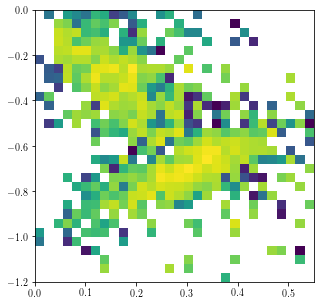

In [73]:
nrows,ncols=1,1
py.figure(figsize=(ncols*5,nrows*5))
ax=py.subplot(111)
ax.set_xlim(0,0.55)
ax.hist2d(_uv1,_dv1,bins=(30),range=((0,0.55),(-1.2,0)), norm=LogNorm());
ax.hist2d(_uv2,_dv2,bins=(30),range=((0,0.55),(-1.2,0)), norm=LogNorm());

#ax.hist2d(_uv2,_dv2,bins=(100),norm=LogNorm());


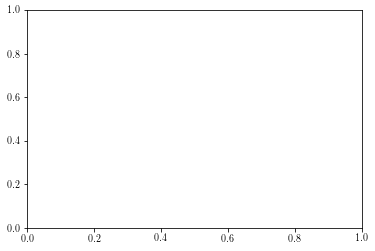

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal

"""
SymLogNorm: two humps, one negative and one positive, The positive
with 5-times the amplitude. Linearly, you cannot see detail in the
negative hump.  Here we logarithmically scale the positive and
negative data separately.

Note that colorbar labels do not come out looking very good.
"""
N=100
X, Y = np.mgrid[-3:3:complex(0, N), -2:2:complex(0, N)]
Z1 = (bivariate_normal(X, Y, 1., 1., 1.0, 1.0))**2  \
    - 0.4 * (bivariate_normal(X, Y, 1.0, 1.0, -1.0, 0.0))**2
Z1 = Z1/0.03

ax = py.subplot(111)

X,Y=np.meshgrid(uv1, dv1,sparse=True)

#pcm = ax.pcolormesh(X,Y,Z1,  norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,vmin=-1.0, vmax=1.0),cmap='RdBu_r')
# fig.colorbar(pcm, ax=ax[0], extend='both')

# pcm = ax[1].pcolormesh(X, Y, Z1, cmap='RdBu_r', vmin=-np.max(Z1))
# fig.colorbar(pcm, ax=ax[1], extend='both')


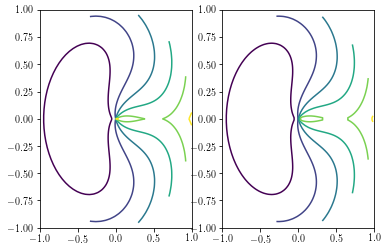

In [106]:


# data on a grid
r = np.linspace(0, 1, 100)
t = np.linspace(0, 2*np.pi, 100)
r, t = np.meshgrid(r, t)
z = (t-np.pi)**2 + 10*(r-0.5)**2

plt.subplot(121)
plt.contour(r*np.cos(t), r*np.sin(t), z)

# ungrid data, then re-grid it
r = r.flatten()
t = t.flatten()
x = r*np.cos(t)
y = r*np.sin(t)
z = z.flatten()
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
zgrid = griddata(x,y,z, xgrid, ygrid,interp='linear')

plt.subplot(122)
plt.contour(xgrid, ygrid, zgrid)




In [101]:
z.shape

(100, 100)

In [65]:
import seaborn as sns
import seaborn
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
#seaborn.set(rc={'axes.facecolor':'w', 'figure.facecolor':'white'})
sns.set_style('white')
sns.set_style('ticks')

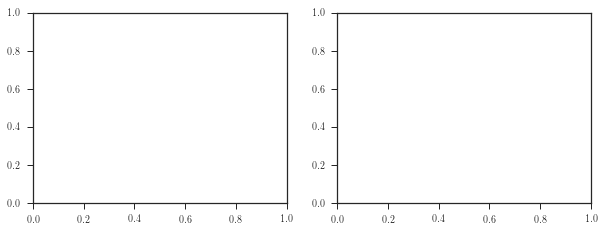

In [66]:
nrows,ncols=1,2
fig, ax=py.subplots(nrows=nrows, ncols=ncols,figsize=(ncols*5,nrows*3.5))

In [67]:
ax[0].clear()
sns.kdeplot(_uv1,_dv1, shade=True,shade_lowest=False,cmap="Blues",ax=ax[0])
sns.kdeplot(_uv2,_dv2, shade=True,shade_lowest=False,cmap="Oranges",ax=ax[0])

In [68]:
toRGB=lambda p: (float(p[0])/255,float(p[1])/255,float(p[2])/255)
ax[1].clear()
R=(0,1.5)
bins=30

#ax[1].hist(gT2,histtype='stepfilled',range=R\
#   ,weights=run2.weights,bins=bins,facecolor='w',normed=True);
ax[1].hist(gT2,histtype='stepfilled',range=R\
   ,weights=run2.weights,bins=bins,facecolor='r'\
    #toRGB((251,105,74))\
   ,edgecolor='k'\
   ,label=r'$\boldsymbol{\rm SIDIS\!+\!lattice}$',normed=True,alpha=0.7,zorder=10);

ax[1].hist(gT1,histtype='stepfilled',range=R\
    ,weights=run1.weights,bins=bins\
    ,facecolor="Yellow",edgecolor='k',alpha=1\
    ,label=r'$\boldsymbol{\rm SIDIS}$',normed=True,zorder=0);

# ax[1].hist(gT1,histtype='step',range=R\
#     ,weights=run1.weights,bins=bins\
#     ,facecolor="none",edgecolor='k',alpha=1\
#     ,normed=True);

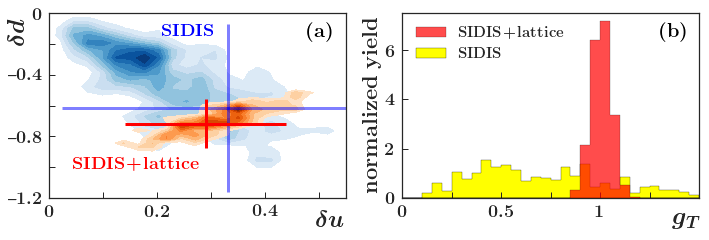

In [69]:
ax[0].tick_params(axis='both', which='major', labelsize=18, direction='in')
ax[0].set_xlabel(r'$\boldsymbol{\delta u}$',size=24)
ax[0].xaxis.set_label_coords(0.95, -0.07)
ax[0].set_xlim(0.0,0.55)
ax[0].set_xticks([0,0.1,0.2,0.3,0.4,0.5])
ax[0].set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.2}$','',r'$\boldsymbol{0.4}$',''])
ax[0].set_ylabel(r'$\boldsymbol{\delta d}$',size=24)
ax[0].yaxis.set_label_coords(-0.07, 0.9)
ax[0].set_ylim(-1.2,0.0)
ax[0].set_yticks([-1.2,-1.0,-0.8,-0.6,-0.4,-0.2,0])
ax[0].set_yticklabels([r'--$\boldsymbol{1.2}$','',r'--$\boldsymbol{0.8}$','',r'--$\boldsymbol{0.4}$','',r'$\boldsymbol{0}$'])
ax[0].text(0.38,0.88,r'$\boldsymbol{\rm SIDIS}$',size=18,transform=ax[0].transAxes,color='b',alpha=1)
ax[0].text(0.08,0.16,r'$\boldsymbol{\rm SIDIS\!+\!lattice}$',size=18,transform=ax[0].transAxes,color='r',alpha=1)
ax[0].errorbar([Euv1],[Edv1],xerr=Suv1,yerr=Sdv1,fmt='b.',elinewidth=3,alpha=0.5)
ax[0].errorbar([Euv2],[Edv2],xerr=Suv2,yerr=Sdv2,fmt='r.',elinewidth=3,alpha=1)
#ax[0].plot([Euv1],[Edv1],'g+',markersize=25)
#ax[0].plot([Euv2],[Edv2],'r+',markersize=25)
ax[0].text(0.87,0.87,r'$\boldsymbol{\rm (a)}$',size=20,transform=ax[0].transAxes,color='k',alpha=1)

ax[1].tick_params(axis='both', which='major', labelsize=18, direction='in')
ax[1].set_xlabel(r'$\boldsymbol{g_T}$',size=25)
ax[1].set_xlim([0,1.5])
ax[1].set_xticks([0,0.25,0.5,0.75,1,1.25])
ax[1].set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.5}$','',r'$\boldsymbol{1}$',''])
ax[1].xaxis.set_label_coords(0.95, -0.07)
ax[1].set_ylabel(r'$\boldsymbol{\rm normalized~yield}$',size=22)
ax[1].set_ylim([0,7.5])
ax[1].set_yticks([0,2,4,6])
ax[1].set_yticklabels([r'$\boldsymbol{0}$',r'$\boldsymbol{2}$',r'$\boldsymbol{4}$',r'$\boldsymbol{6}$'])
ax[1].legend(frameon=False,fontsize=15,loc=2)
ax[1].text(0.87,0.87,r'$\boldsymbol{\rm (b)}$',size=20,transform=ax[1].transAxes,color='k',alpha=1)


fig.tight_layout()
#fig.savefig('/Users/wmelnitc/Physics/Papers/TMD/gT17/paper/prl_final/gT.pdf')
fig

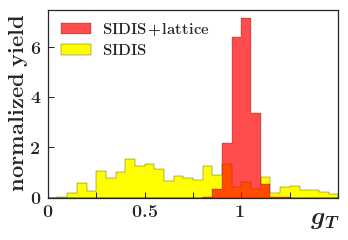

In [64]:
nrows,ncols=1,1
fig, ax=py.subplots(nrows=nrows, ncols=ncols,figsize=(ncols*5,nrows*3.5))
toRGB=lambda p: (float(p[0])/255,float(p[1])/255,float(p[2])/255)
ax.clear()
R=(0,1.5)
bins=30

#ax[1].hist(gT2,histtype='stepfilled',range=R\
#   ,weights=run2.weights,bins=bins,facecolor='w',normed=True);
ax.hist(gT2,histtype='stepfilled',range=R\
   ,weights=run2.weights,bins=bins,facecolor='r'\
    #toRGB((251,105,74))\
   ,edgecolor='k'\
   ,label=r'$\boldsymbol{\rm SIDIS\!+\!lattice}$',normed=True,alpha=0.7,zorder=10);

ax.hist(gT1,histtype='stepfilled',range=R\
    ,weights=run1.weights,bins=bins\
    ,facecolor="Yellow",edgecolor='k',alpha=1\
    ,label=r'$\boldsymbol{\rm SIDIS}$',normed=True,zorder=0);

ax.tick_params(axis='both', which='major', labelsize=18, direction='in')
ax.set_xlabel(r'$\boldsymbol{g_T}$',size=25)
ax.set_xlim([0,1.5])
ax.set_xticks([0,0.25,0.5,0.75,1,1.25])
ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.5}$','',r'$\boldsymbol{1}$',''])
ax.xaxis.set_label_coords(0.95, -0.07)
ax.set_ylabel(r'$\boldsymbol{\rm normalized~yield}$',size=22)
ax.set_ylim([0,7.5])
ax.set_yticks([0,2,4,6])
ax.set_yticklabels([r'$\boldsymbol{0}$',r'$\boldsymbol{2}$',r'$\boldsymbol{4}$',r'$\boldsymbol{6}$'])
ax.legend(frameon=False,fontsize=15,loc=2)
#ax.text(0.87,0.87,r'$\boldsymbol{\rm (b)}$',size=20,transform=ax.transAxes,color='k',alpha=1)

# ax[1].hist(gT1,histtype='step',range=R\
#     ,weights=run1.weights,bins=bins\
#     ,facecolor="none",edgecolor='k',alpha=1\
#     ,normed=True);
py.tight_layout()
py.savefig('gT.pdf')